# Insights from Failed Orders
source: https://platform.stratascratch.com/data-projects/insights-failed-orders

In [190]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [12]:
offer = pd.read_csv("./datasets/data_offers.csv")
orders = pd.read_csv("./datasets/data_orders.csv")

print(offer.info())
print(orders.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334363 entries, 0 to 334362
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   order_gk  334363 non-null  int64
 1   offer_id  334363 non-null  int64
dtypes: int64(2)
memory usage: 5.1 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-nu

In [19]:
orders.isna().sum()
print(orders.describe())

       origin_longitude  origin_latitude  m_order_eta      order_gk  \
count      10716.000000     10716.000000  2814.000000  1.071600e+04   
mean          -0.964323        51.450541   441.415423  3.000598e+12   
std            0.022818         0.011984   288.006379  2.396261e+07   
min           -1.066957        51.399323    60.000000  3.000550e+12   
25%           -0.974363        51.444643   233.000000  3.000583e+12   
50%           -0.966386        51.451972   368.500000  3.000595e+12   
75%           -0.949605        51.456725   653.000000  3.000623e+12   
max           -0.867088        51.496169  1559.000000  3.000633e+12   

       order_status_key  is_driver_assigned_key  cancellations_time_in_seconds  
count      10716.000000            10716.000000                    7307.000000  
mean           5.590612                0.262598                     157.892021  
std            2.328845                0.440066                     213.366963  
min            4.000000             

['order_datetime']

In [186]:
orders2 = orders.assign(
    reason=lambda x: x.order_status_key.case_when(
        [
            (
                (x.order_status_key == 4) & (x.is_driver_assigned_key == 1),
                "Cancelled by Client after driver is assigned",
            ),
            (
                (x.order_status_key == 4) & (x.is_driver_assigned_key == 0),
                "Cancelled by Client before driver is assigned",
            ),
            (
                (x.order_status_key == 9) & (x.is_driver_assigned_key == 1),
                "Cancelled by driver after driver is assigned",
            ),
            (
                (x.order_status_key == 9) & (x.is_driver_assigned_key == 0),
                "Cancelled by system before driver is assigned",
            ),
        ]
    ),
    order_hour=lambda x: x.order_datetime.apply(lambda x: x[:2]),
    cancellations_time_in_mins=lambda x: x.cancellations_time_in_seconds / 60,
    eta_in_mins=lambda x: x.m_order_eta / 60,
)

### (1) Distribution of reasons for failed orders

In [32]:
reason_distribution = orders2.groupby("reason", as_index=False).agg(
    count=("order_gk", "count")
)

reason_distribution

,reason,count
0,Cancelled by Client after driver is assigned,2811
1,Cancelled by Client before driver is assigned,4496
2,Cancelled by driver after driver is assigned,3
3,Cancelled by system before driver is assigned,3406


<Axes: xlabel='Count', ylabel='reason'>

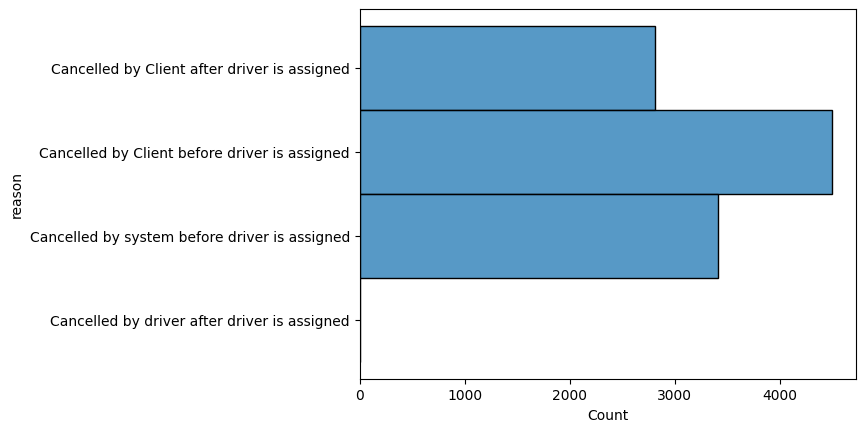

In [ ]:
sns.histplot(data=orders2, y="reason")

The most frequent reason for order cancellation is "Cancelled by Client before driver is assigned". 
The second most frequent reason is "Cancelled by Client after driver is assigned". 
The least frequent reason is "Cancelled by driver after driver is assigned".

### (2) Distribution of failed orders by hour

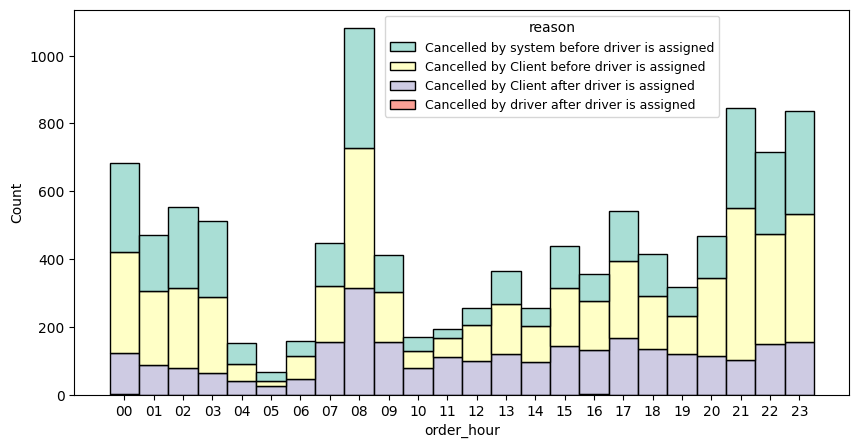

In [129]:
plt.figure(figsize=(10, 5))
orders2 = orders2.sort_values("order_datetime")
ax = sns.histplot(
    data=orders2, x="order_hour", hue="reason", multiple="stack", palette="Set3"
)
sns.move_legend(ax, "upper right", bbox_to_anchor=(0.84, 1), fontsize=9)

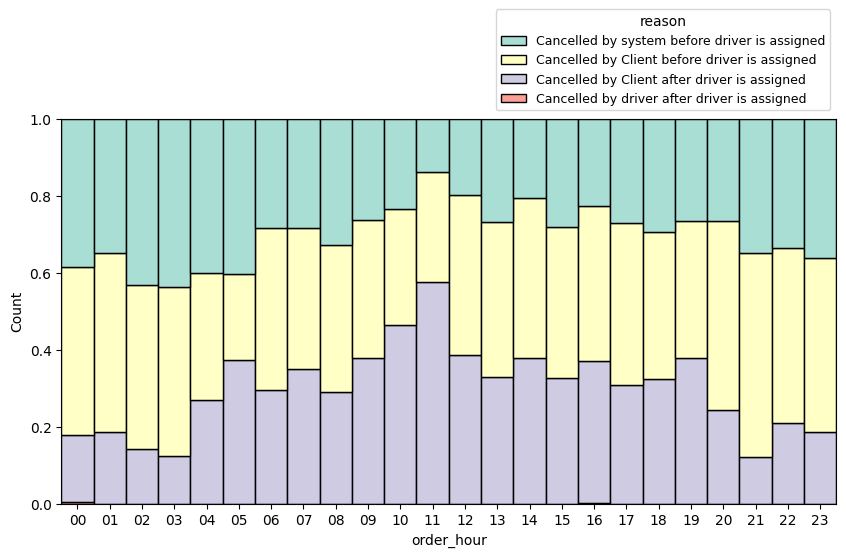

In [188]:
plt.figure(figsize=(10, 5))
orders2 = orders2.sort_values("order_datetime")
ax = sns.histplot(
    data=orders2, x="order_hour", hue="reason", multiple="fill", palette="Set3"
)
sns.move_legend(ax, "upper right", bbox_to_anchor=(1, 1.3), fontsize=9)

Cancellation by client after driver is assigned has the highest proprotion at 11AM. This may due to the fact clients has more choices of drivers and not in a hurry of getting to work or home.

The total number of cancellation is highest around 8AM. This might be because this is the morning rush commute hours, system may not be able to match a driver for all request, or clients would cancel to choice other means of transportaion when wait is too long. Cancellation is also high between night time 9PM and 3AM. This may driven by less number of drivers available for hire.

### (3) Average cancellation time

In [149]:
orders2.groupby("is_driver_assigned_key", as_index=False).agg(
    cancel_time_min=("cancellations_time_in_mins", "min"),
    cancel_time_q50=("cancellations_time_in_mins", lambda x: x.quantile(0.5)),
    cancel_time_q75=("cancellations_time_in_mins", lambda x: x.quantile(0.75)),
    cancel_time_q95=("cancellations_time_in_mins", lambda x: x.quantile(0.95)),
    cancel_time_max=("cancellations_time_in_mins", "max"),
)


,is_driver_assigned_key,cancel_time_min,cancel_time_q50,cancel_time_q75,cancel_time_q95,cancel_time_max
0,0,0.05,1.466667,2.616667,4.066667,68.283333
1,1,0.10,2.116667,4.933333,12.958333,71.716667


Cap cancel time at 95th percentile by 'driver assigned' status

In [179]:
orders3 = orders2.assign(
    cancellations_time_in_mins_capped=lambda x: np.where(
        x.is_driver_assigned_key == 1,
        x.cancellations_time_in_mins.clip(0, 13),
        x.cancellations_time_in_mins.clip(0, 4),
    )
)

orders3.groupby("is_driver_assigned_key", as_index=False).agg(
    cancel_time_N=("cancellations_time_in_mins_capped", "count"),
    cancel_time_min=("cancellations_time_in_mins_capped", "min"),
    cancel_time_mean=("cancellations_time_in_mins_capped", "mean"),
    cancel_time_q50=("cancellations_time_in_mins_capped", lambda x: x.quantile(0.5)),
    cancel_time_max=("cancellations_time_in_mins_capped", "max"),
)

,is_driver_assigned_key,cancel_time_N,cancel_time_min,cancel_time_mean,cancel_time_q50,cancel_time_max
0,0,4496,0.05,1.691333,1.466667,4.0
1,1,2811,0.10,3.600783,2.116667,13.0


<Axes: xlabel='order_hour', ylabel='cancellations_time_in_mins_capped'>

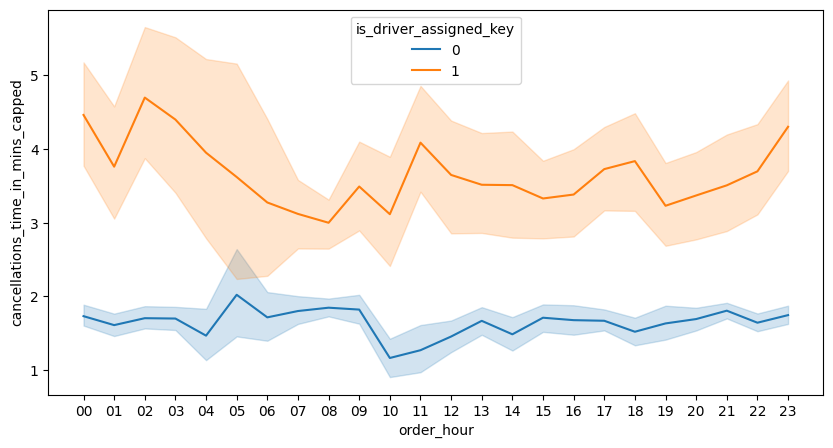

In [230]:
plt.figure(figsize=(10, 5))
orders3 = orders3.sort_values("order_hour")
sns.lineplot(
    orders3,
    x="order_hour",
    y="cancellations_time_in_mins_capped",
    hue="is_driver_assigned_key",
)


The mean time for a cancellation is 1.7 minutes when the driver is not assigned and 3.6 minutes when the driver is assigned.

### (4) Average ETA by hour

In [185]:
orders2.h_eta.describe()

count    2814.000000
mean        7.356924
std         4.800106
min         1.000000
25%         3.883333
50%         6.141667
75%        10.883333
max        25.983333
Name: h_eta, dtype: float64

<Axes: xlabel='order_hour', ylabel='eta_in_mins'>

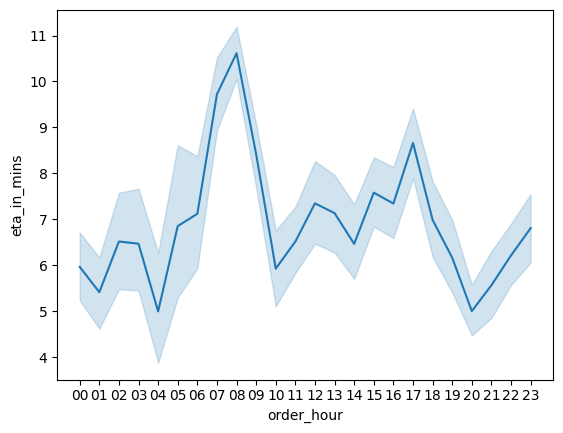

In [189]:
sns.lineplot(orders2, x="order_hour", y="eta_in_mins")

ETA peaks at 8PM and 5PM which are typically rush hours. ETA is minimum around 8PM and 4AM which are typically less congested hours

### (5) Map

In [223]:
px.scatter_map(
    orders,
    lat="origin_latitude",
    lon="origin_longitude",
    opacity=0.2,
    zoom=11,
    map_style="carto-voyager",
)
